前排定义一下训练参数

In [1]:
import os
# 训练循环次数
num_epochs = 50

# batch大小
batch_size = 256

# lstm层中包含的unit个数
rnn_size = 256

# lstm层数
num_layers = 3

# 训练步长
seq_length = 30

# 学习率
learning_rate = 0.001

#dropout keep
output_keep_prob = 0.8
input_keep_prob = 1.0

# 优化器
grad_clip = 5.

decay_rate = 0.97
init_from = None
save_every = 1000
# 保存模型
save_dir = './save'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
    assert False, "你为创建保存模型文件，已为你创建 文件夹名：save"
# 保存logs   
log_dir = './logs'
if not os.path.isdir(log_dir):
    os.makedirs(log_dir)
    assert False, "你为创建logs文件，已为你创建 文件夹名：logs"
# 保存数据和词汇
data_dir = './temp'
if not os.path.isdir(data_dir):
    os.makedirs(data_dir)
    assert False, "你为创建数据储存文件，已为你创建 文件夹名：temp"
    
input_file = os.path.join(data_dir, "爵迹I II.txt")
if not os.path.exists(input_file): 
    print('请将郭小四的小说放到temp文件夹下....')  
vocab_file = os.path.join(data_dir, "vocab.pkl")
tensor_file = os.path.join(data_dir, "data.npy")
_file = os.path.join(save_dir, 'chars_vocab.pkl')

首先加载数据集 <p>
使用到的是**`爵迹`**这本小说<p>
无论小说和电影都能给人很深刻的印象....

In [3]:
with open(input_file, 'r',encoding = 'gbk') as f:
        text = f.read()

**预览一下部分内容<p>**
果然一股东方神话、字里行间透露出45度角仰望天空的忧伤气息扑面而来<p>

In [4]:
text[500:800]

'而来？传说中至高无上的【白银祭司】又掌握着怎样的真相？这场旷世之战，究竟要将主角的命运引向王者的宝座，还是惨烈的死亡？\n\n    \n\n    序章  神遇\n\n    \n\n    漫天翻滚的碎雪，仿佛巨兽抖落的白色绒毛，纷纷扬扬地遮蔽着视线。\n\n    这块大陆的冬天已经来临。\n\n    南方只是开始不易察觉地降温，凌晨的时候窗棂上会看见霜花，但是在这里——大陆接近极北的尽头，已经是一望无际的苍茫肃杀。大块大块浮动在海面上的冰山彼此不时地撞击着，在天地间发出巨大的锐利轰鸣声，坍塌的冰块砸进大海，掀起白色的浪涛。辽阔的黑色冻土在接连几天的大雪之后，变成了一片茫茫的雪原。这已经是深北之地了，连绵不断'

* 做一些数据预处理，去掉一写无关的字符和空格，去掉书籍前几行没用的介绍

In [5]:
import re
pattern = re.compile('\[.*\]|<.*>|\.+|【|】| +|\\r|\\n')
text = pattern.sub('', text.strip()) 

In [6]:
text[500:800]

'巨兽抖落的白色绒毛，纷纷扬扬地遮蔽着视线。这块大陆的冬天已经来临。南方只是开始不易察觉地降温，凌晨的时候窗棂上会看见霜花，但是在这里——大陆接近极北的尽头，已经是一望无际的苍茫肃杀。大块大块浮动在海面上的冰山彼此不时地撞击着，在天地间发出巨大的锐利轰鸣声，坍塌的冰块砸进大海，掀起白色的浪涛。辽阔的黑色冻土在接连几天的大雪之后，变成了一片茫茫的雪原。这已经是深北之地了，连绵不断的冰川仿佛怪兽的利齿般将天地的尽头紧紧咬在一起，地平线消失在刺眼的白色冰面之下。天空被厚重的云层遮挡，光线仿佛蒙着一层尘埃，混沌地洒向大地。混沌的风雪在空旷的天地间吹出一阵又一阵仿佛狼嗥般的凄厉声响。拳头大小的纷乱大雪里，'

####  感觉预处理后效果还可以.没那么乱了，开始做词映射
1. 首先做词频统计，再降序排序，因为用的是char级的所以这一步是没什么必要的，统计有多少个汉字和字符，其实可以用``chars=set(text)``代替
2. 将统计结果作为语料库，存入本地pkl文件中，方便调用

In [7]:
import collections
from six.moves import cPickle
counter = collections.Counter(text)
counter = sorted(counter.items(), key=lambda x: -x[1])
chars, _  = zip(*counter)
with open(vocab_file, 'wb') as f:
    cPickle.dump(chars, f)

对词汇表字符(包括\n哦)做一个数字索引，并用这个数字索引来代替这个汉字<p>
保存字词映射表

In [8]:
vocab_size = len(chars)
vocab = dict(zip(chars, range(vocab_size)))
with open(_file, 'wb') as f:
    cPickle.dump((chars, vocab), f)

1. 将整本书的内容，做一下 汉字/字符  - 数字 的变化。
2. 这样原来的一本书变可以用一个由N个数字组成的列表表示了
3. 最后把向量化的这本书保存下来，方便之后调用

In [9]:
import numpy as np
text_tensor = np.array(list(map(vocab.get, text)))
np.save(tensor_file, text_tensor)

构建训练所需数据格式

In [10]:
num_batches = int(text_tensor.size / (batch_size * seq_length))

if num_batches == 0:
    assert False, "Not enough data. Make seq_length and batch_size small."

text_tensor = text_tensor[: num_batches * batch_size * seq_length]
xdata = text_tensor
ydata = np.copy(text_tensor)

#循环神经网络，最后一个输出为最先一个输入
ydata[:-1] = xdata[1:]
ydata[-1] = xdata[0]
x_batches = np.split(xdata.reshape( batch_size, -1),
                          num_batches, 1)
y_batches = np.split(ydata.reshape(batch_size, -1),
                          num_batches, 1)

构建一个生成器,生成批次数据

In [11]:
def next_batch(pointer):
    x, y = x_batches[pointer], y_batches[pointer]
    return x, y  

In [12]:
import time
import tensorflow as tf
from tensorflow.contrib import rnn
from tensorflow.contrib import legacy_seq2seq

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## 训练模式

In [13]:
training = True

构建LSTM的cell

In [14]:
if not training:
    batch_size = 1
    seq_length = 1

In [15]:
cells = []
for _ in range(num_layers):
    cell = rnn.LSTMCell(rnn_size)
    if training and (output_keep_prob < 1.0 or input_keep_prob < 1.0):
        cell = rnn.DropoutWrapper(cell,
                                  input_keep_prob=input_keep_prob,
                                  output_keep_prob=output_keep_prob)
    cells.append(cell)
cell = rnn.MultiRNNCell(cells, state_is_tuple=True)

初始化占位符,随机化参数矩阵，

In [16]:
input_data = tf.placeholder(tf.int32, [batch_size, seq_length])
targets = tf.placeholder(tf.int32, [batch_size, seq_length])
initial_state = cell.zero_state(batch_size, tf.float32)

with tf.variable_scope('rnnlm'):
    softmax_w = tf.get_variable("softmax_w",[rnn_size, vocab_size])
    softmax_b = tf.get_variable("softmax_b", [vocab_size])

将input转化为词嵌入向量

In [17]:
embedding = tf.get_variable("embedding", [vocab_size, rnn_size])
inputs = tf.nn.embedding_lookup(embedding, input_data)

In [18]:
# dropout beta testing: double check which one should affect next line
if training and output_keep_prob:
    inputs = tf.nn.dropout(inputs, output_keep_prob)

拆散input_data放入rnn模型

In [19]:
inputs = tf.split(inputs, seq_length, 1)
inputs = [tf.squeeze(input_, [1]) for input_ in inputs]

decoder的输出和最终状态

In [20]:
outputs, last_state = legacy_seq2seq.rnn_decoder(inputs, initial_state, cell,  scope='rnnlm')
output = tf.reshape(tf.concat(outputs, 1), [-1, rnn_size])

对输出层做softmax

In [21]:
logits = tf.matmul(output, softmax_w) + softmax_b
probs = tf.nn.softmax(logits)

loss

In [22]:
loss = legacy_seq2seq.sequence_loss_by_example(
        [logits],
        [tf.reshape(targets, [-1])],
        [tf.ones([batch_size * seq_length])])
with tf.name_scope('cost'):
    cost = tf.reduce_sum(loss) / batch_size / seq_length
final_state = last_state
lr = tf.Variable(0.0, trainable=False)
tvars = tf.trainable_variables()

优化器

In [23]:
grads, _ = tf.clip_by_global_norm(tf.gradients(cost, tvars),grad_clip)
with tf.name_scope('optimizer'):
    optimizer = tf.train.AdamOptimizer(lr)

In [24]:
train_op = optimizer.apply_gradients(zip(grads, tvars))

开始训练

In [25]:
train_loss_result = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver(tf.global_variables())
    # restore model
    if init_from is not None:
        saver.restore(sess, ckpt)
    
    for i in range(num_epochs):
        sess.run(tf.assign(lr,learning_rate * (decay_rate ** i)))
        state = sess.run(initial_state)
        pointer = 0
        for j in range(num_batches):
            start = time.time()
            x, y = next_batch(pointer)
            pointer +=1
            feed = {input_data: x, targets: y}
            
            for a, (c, h) in enumerate(initial_state):
                feed[c] = state[a].c
                feed[h] = state[a].h

      
            train_loss, state, _ = sess.run([ cost, final_state,train_op], feed)
            train_loss_result.append(train_loss)

            end = time.time()
            print("{}/{} (epoch {}), train_loss = {:.3f}, time/batch = {:.3f}"
                  .format(i * num_batches + j,
                          num_epochs * num_batches,
                          i, train_loss, end - start))
            if (i * num_batches + j) % save_every == 0\
                    or (i == num_epochs-1 and
                        j == num_batches-1):
                # save for the last result
                checkpoint_path = os.path.join(save_dir, 'model.ckpt')
                saver.save(sess, checkpoint_path,
                           global_step=i * num_batches + j)
                print("model saved to {}".format(checkpoint_path))

0/1900 (epoch 0), train_loss = 7.984, time/batch = 1.455
model saved to ./save\model.ckpt
1/1900 (epoch 0), train_loss = 7.982, time/batch = 1.354
2/1900 (epoch 0), train_loss = 7.975, time/batch = 1.209
3/1900 (epoch 0), train_loss = 7.949, time/batch = 1.164
4/1900 (epoch 0), train_loss = 7.835, time/batch = 1.171
5/1900 (epoch 0), train_loss = 7.539, time/batch = 1.180
6/1900 (epoch 0), train_loss = 7.251, time/batch = 1.163
7/1900 (epoch 0), train_loss = 7.036, time/batch = 1.179
8/1900 (epoch 0), train_loss = 6.815, time/batch = 1.173
9/1900 (epoch 0), train_loss = 6.602, time/batch = 1.213
10/1900 (epoch 0), train_loss = 6.440, time/batch = 1.647
11/1900 (epoch 0), train_loss = 6.308, time/batch = 1.394
12/1900 (epoch 0), train_loss = 6.246, time/batch = 1.418
13/1900 (epoch 0), train_loss = 6.185, time/batch = 1.612
14/1900 (epoch 0), train_loss = 6.175, time/batch = 1.733
15/1900 (epoch 0), train_loss = 6.210, time/batch = 1.569
16/1900 (epoch 0), train_loss = 6.205, time/batch

141/1900 (epoch 3), train_loss = 6.121, time/batch = 1.489
142/1900 (epoch 3), train_loss = 6.110, time/batch = 1.219
143/1900 (epoch 3), train_loss = 6.144, time/batch = 1.168
144/1900 (epoch 3), train_loss = 6.070, time/batch = 1.153
145/1900 (epoch 3), train_loss = 6.149, time/batch = 1.167
146/1900 (epoch 3), train_loss = 6.148, time/batch = 1.156
147/1900 (epoch 3), train_loss = 6.109, time/batch = 1.204
148/1900 (epoch 3), train_loss = 6.106, time/batch = 1.296
149/1900 (epoch 3), train_loss = 6.154, time/batch = 1.260
150/1900 (epoch 3), train_loss = 6.137, time/batch = 1.336
151/1900 (epoch 3), train_loss = 6.148, time/batch = 1.197
152/1900 (epoch 4), train_loss = 6.215, time/batch = 1.197
153/1900 (epoch 4), train_loss = 6.119, time/batch = 1.413
154/1900 (epoch 4), train_loss = 6.132, time/batch = 1.774
155/1900 (epoch 4), train_loss = 6.116, time/batch = 1.733
156/1900 (epoch 4), train_loss = 6.146, time/batch = 1.533
157/1900 (epoch 4), train_loss = 6.167, time/batch = 1.4

280/1900 (epoch 7), train_loss = 6.110, time/batch = 1.259
281/1900 (epoch 7), train_loss = 6.151, time/batch = 1.453
282/1900 (epoch 7), train_loss = 6.145, time/batch = 1.473
283/1900 (epoch 7), train_loss = 6.108, time/batch = 1.259
284/1900 (epoch 7), train_loss = 6.117, time/batch = 1.517
285/1900 (epoch 7), train_loss = 6.134, time/batch = 1.408
286/1900 (epoch 7), train_loss = 6.141, time/batch = 1.436
287/1900 (epoch 7), train_loss = 6.145, time/batch = 1.576
288/1900 (epoch 7), train_loss = 6.092, time/batch = 1.655
289/1900 (epoch 7), train_loss = 6.118, time/batch = 1.657
290/1900 (epoch 7), train_loss = 6.156, time/batch = 1.598
291/1900 (epoch 7), train_loss = 6.138, time/batch = 1.506
292/1900 (epoch 7), train_loss = 6.124, time/batch = 1.505
293/1900 (epoch 7), train_loss = 6.114, time/batch = 1.338
294/1900 (epoch 7), train_loss = 6.107, time/batch = 1.709
295/1900 (epoch 7), train_loss = 6.136, time/batch = 1.294
296/1900 (epoch 7), train_loss = 6.065, time/batch = 1.6

419/1900 (epoch 11), train_loss = 6.111, time/batch = 1.279
420/1900 (epoch 11), train_loss = 6.113, time/batch = 1.441
421/1900 (epoch 11), train_loss = 6.099, time/batch = 1.607
422/1900 (epoch 11), train_loss = 6.128, time/batch = 1.685
423/1900 (epoch 11), train_loss = 6.150, time/batch = 1.347
424/1900 (epoch 11), train_loss = 6.115, time/batch = 1.376
425/1900 (epoch 11), train_loss = 6.153, time/batch = 1.402
426/1900 (epoch 11), train_loss = 6.125, time/batch = 1.476
427/1900 (epoch 11), train_loss = 6.100, time/batch = 1.438
428/1900 (epoch 11), train_loss = 6.097, time/batch = 1.290
429/1900 (epoch 11), train_loss = 6.083, time/batch = 1.247
430/1900 (epoch 11), train_loss = 6.109, time/batch = 1.277
431/1900 (epoch 11), train_loss = 6.099, time/batch = 1.421
432/1900 (epoch 11), train_loss = 6.100, time/batch = 1.348
433/1900 (epoch 11), train_loss = 6.146, time/batch = 1.333
434/1900 (epoch 11), train_loss = 6.141, time/batch = 1.383
435/1900 (epoch 11), train_loss = 6.105,

556/1900 (epoch 14), train_loss = 6.146, time/batch = 1.495
557/1900 (epoch 14), train_loss = 6.134, time/batch = 1.751
558/1900 (epoch 14), train_loss = 6.115, time/batch = 1.768
559/1900 (epoch 14), train_loss = 6.108, time/batch = 1.458
560/1900 (epoch 14), train_loss = 6.097, time/batch = 1.229
561/1900 (epoch 14), train_loss = 6.126, time/batch = 1.307
562/1900 (epoch 14), train_loss = 6.057, time/batch = 1.379
563/1900 (epoch 14), train_loss = 6.131, time/batch = 1.364
564/1900 (epoch 14), train_loss = 6.133, time/batch = 1.333
565/1900 (epoch 14), train_loss = 6.093, time/batch = 1.357
566/1900 (epoch 14), train_loss = 6.093, time/batch = 1.356
567/1900 (epoch 14), train_loss = 6.137, time/batch = 1.340
568/1900 (epoch 14), train_loss = 6.121, time/batch = 1.494
569/1900 (epoch 14), train_loss = 6.137, time/batch = 1.757
570/1900 (epoch 15), train_loss = 6.139, time/batch = 1.585
571/1900 (epoch 15), train_loss = 6.104, time/batch = 1.462
572/1900 (epoch 15), train_loss = 6.109,

693/1900 (epoch 18), train_loss = 6.089, time/batch = 1.549
694/1900 (epoch 18), train_loss = 6.088, time/batch = 1.532
695/1900 (epoch 18), train_loss = 6.077, time/batch = 1.530
696/1900 (epoch 18), train_loss = 6.102, time/batch = 1.504
697/1900 (epoch 18), train_loss = 6.090, time/batch = 1.440
698/1900 (epoch 18), train_loss = 6.095, time/batch = 1.669
699/1900 (epoch 18), train_loss = 6.137, time/batch = 1.637
700/1900 (epoch 18), train_loss = 6.136, time/batch = 1.634
701/1900 (epoch 18), train_loss = 6.101, time/batch = 1.474
702/1900 (epoch 18), train_loss = 6.107, time/batch = 1.619
703/1900 (epoch 18), train_loss = 6.123, time/batch = 1.264
704/1900 (epoch 18), train_loss = 6.124, time/batch = 1.274
705/1900 (epoch 18), train_loss = 6.133, time/batch = 1.373
706/1900 (epoch 18), train_loss = 6.077, time/batch = 1.384
707/1900 (epoch 18), train_loss = 6.108, time/batch = 1.296
708/1900 (epoch 18), train_loss = 6.142, time/batch = 1.354
709/1900 (epoch 18), train_loss = 6.131,

830/1900 (epoch 21), train_loss = 6.124, time/batch = 1.569
831/1900 (epoch 21), train_loss = 6.089, time/batch = 1.558
832/1900 (epoch 21), train_loss = 6.085, time/batch = 1.395
833/1900 (epoch 21), train_loss = 6.130, time/batch = 1.414
834/1900 (epoch 21), train_loss = 6.113, time/batch = 1.262
835/1900 (epoch 21), train_loss = 6.127, time/batch = 1.434
836/1900 (epoch 22), train_loss = 6.128, time/batch = 1.267
837/1900 (epoch 22), train_loss = 6.109, time/batch = 1.292
838/1900 (epoch 22), train_loss = 6.104, time/batch = 1.387
839/1900 (epoch 22), train_loss = 6.087, time/batch = 1.334
840/1900 (epoch 22), train_loss = 6.115, time/batch = 1.216
841/1900 (epoch 22), train_loss = 6.137, time/batch = 1.315
842/1900 (epoch 22), train_loss = 6.106, time/batch = 1.270
843/1900 (epoch 22), train_loss = 6.139, time/batch = 1.336
844/1900 (epoch 22), train_loss = 6.115, time/batch = 1.395
845/1900 (epoch 22), train_loss = 6.087, time/batch = 1.266
846/1900 (epoch 22), train_loss = 6.087,

967/1900 (epoch 25), train_loss = 6.093, time/batch = 1.262
968/1900 (epoch 25), train_loss = 6.101, time/batch = 1.246
969/1900 (epoch 25), train_loss = 6.120, time/batch = 1.243
970/1900 (epoch 25), train_loss = 6.121, time/batch = 1.257
971/1900 (epoch 25), train_loss = 6.129, time/batch = 1.243
972/1900 (epoch 25), train_loss = 6.074, time/batch = 1.281
973/1900 (epoch 25), train_loss = 6.103, time/batch = 1.283
974/1900 (epoch 25), train_loss = 6.136, time/batch = 1.246
975/1900 (epoch 25), train_loss = 6.125, time/batch = 1.252
976/1900 (epoch 25), train_loss = 6.109, time/batch = 1.251
977/1900 (epoch 25), train_loss = 6.095, time/batch = 1.252
978/1900 (epoch 25), train_loss = 6.090, time/batch = 1.231
979/1900 (epoch 25), train_loss = 6.118, time/batch = 1.242
980/1900 (epoch 25), train_loss = 6.053, time/batch = 1.264
981/1900 (epoch 25), train_loss = 6.124, time/batch = 1.242
982/1900 (epoch 25), train_loss = 6.122, time/batch = 1.232
983/1900 (epoch 25), train_loss = 6.083,

1102/1900 (epoch 29), train_loss = 6.060, time/batch = 1.276
1103/1900 (epoch 29), train_loss = 6.021, time/batch = 1.249
1104/1900 (epoch 29), train_loss = 6.013, time/batch = 1.255
1105/1900 (epoch 29), train_loss = 5.994, time/batch = 1.259
1106/1900 (epoch 29), train_loss = 6.018, time/batch = 1.255
1107/1900 (epoch 29), train_loss = 6.035, time/batch = 1.261
1108/1900 (epoch 29), train_loss = 6.001, time/batch = 1.283
1109/1900 (epoch 29), train_loss = 6.038, time/batch = 1.335
1110/1900 (epoch 29), train_loss = 6.006, time/batch = 1.282
1111/1900 (epoch 29), train_loss = 5.971, time/batch = 1.247
1112/1900 (epoch 29), train_loss = 5.976, time/batch = 1.253
1113/1900 (epoch 29), train_loss = 5.957, time/batch = 1.269
1114/1900 (epoch 29), train_loss = 5.983, time/batch = 1.256
1115/1900 (epoch 29), train_loss = 5.975, time/batch = 1.250
1116/1900 (epoch 29), train_loss = 5.984, time/batch = 1.279
1117/1900 (epoch 29), train_loss = 6.022, time/batch = 1.263
1118/1900 (epoch 29), tr

1237/1900 (epoch 32), train_loss = 5.846, time/batch = 1.324
1238/1900 (epoch 32), train_loss = 5.797, time/batch = 1.299
1239/1900 (epoch 32), train_loss = 5.825, time/batch = 1.275
1240/1900 (epoch 32), train_loss = 5.845, time/batch = 1.280
1241/1900 (epoch 32), train_loss = 5.832, time/batch = 1.271
1242/1900 (epoch 32), train_loss = 5.821, time/batch = 1.296
1243/1900 (epoch 32), train_loss = 5.796, time/batch = 1.314
1244/1900 (epoch 32), train_loss = 5.806, time/batch = 1.367
1245/1900 (epoch 32), train_loss = 5.821, time/batch = 1.411
1246/1900 (epoch 32), train_loss = 5.762, time/batch = 1.493
1247/1900 (epoch 32), train_loss = 5.819, time/batch = 1.588
1248/1900 (epoch 32), train_loss = 5.829, time/batch = 1.507
1249/1900 (epoch 32), train_loss = 5.794, time/batch = 1.541
1250/1900 (epoch 32), train_loss = 5.786, time/batch = 1.560
1251/1900 (epoch 32), train_loss = 5.827, time/batch = 1.457
1252/1900 (epoch 32), train_loss = 5.808, time/batch = 1.396
1253/1900 (epoch 32), tr

1372/1900 (epoch 36), train_loss = 5.740, time/batch = 1.222
1373/1900 (epoch 36), train_loss = 5.761, time/batch = 1.180
1374/1900 (epoch 36), train_loss = 5.710, time/batch = 1.207
1375/1900 (epoch 36), train_loss = 5.755, time/batch = 1.212
1376/1900 (epoch 36), train_loss = 5.741, time/batch = 1.189
1377/1900 (epoch 36), train_loss = 5.704, time/batch = 1.320
1378/1900 (epoch 36), train_loss = 5.712, time/batch = 1.187
1379/1900 (epoch 36), train_loss = 5.687, time/batch = 1.215
1380/1900 (epoch 36), train_loss = 5.712, time/batch = 1.186
1381/1900 (epoch 36), train_loss = 5.707, time/batch = 1.200
1382/1900 (epoch 36), train_loss = 5.720, time/batch = 1.204
1383/1900 (epoch 36), train_loss = 5.745, time/batch = 1.180
1384/1900 (epoch 36), train_loss = 5.744, time/batch = 1.192
1385/1900 (epoch 36), train_loss = 5.700, time/batch = 1.213
1386/1900 (epoch 36), train_loss = 5.716, time/batch = 1.210
1387/1900 (epoch 36), train_loss = 5.735, time/batch = 1.188
1388/1900 (epoch 36), tr

1507/1900 (epoch 39), train_loss = 5.686, time/batch = 1.159
1508/1900 (epoch 39), train_loss = 5.684, time/batch = 1.368
1509/1900 (epoch 39), train_loss = 5.656, time/batch = 1.630
1510/1900 (epoch 39), train_loss = 5.663, time/batch = 1.484
1511/1900 (epoch 39), train_loss = 5.676, time/batch = 1.411
1512/1900 (epoch 39), train_loss = 5.624, time/batch = 1.453
1513/1900 (epoch 39), train_loss = 5.667, time/batch = 1.298
1514/1900 (epoch 39), train_loss = 5.689, time/batch = 1.330
1515/1900 (epoch 39), train_loss = 5.655, time/batch = 1.181
1516/1900 (epoch 39), train_loss = 5.649, time/batch = 1.157
1517/1900 (epoch 39), train_loss = 5.680, time/batch = 1.325
1518/1900 (epoch 39), train_loss = 5.672, time/batch = 1.430
1519/1900 (epoch 39), train_loss = 5.690, time/batch = 1.336
1520/1900 (epoch 40), train_loss = 5.736, time/batch = 1.230
1521/1900 (epoch 40), train_loss = 5.677, time/batch = 1.401
1522/1900 (epoch 40), train_loss = 5.673, time/batch = 1.366
1523/1900 (epoch 40), tr

1642/1900 (epoch 43), train_loss = 5.627, time/batch = 1.532
1643/1900 (epoch 43), train_loss = 5.597, time/batch = 1.589
1644/1900 (epoch 43), train_loss = 5.607, time/batch = 1.582
1645/1900 (epoch 43), train_loss = 5.573, time/batch = 1.435
1646/1900 (epoch 43), train_loss = 5.599, time/batch = 1.370
1647/1900 (epoch 43), train_loss = 5.599, time/batch = 1.490
1648/1900 (epoch 43), train_loss = 5.616, time/batch = 1.440
1649/1900 (epoch 43), train_loss = 5.639, time/batch = 1.598
1650/1900 (epoch 43), train_loss = 5.632, time/batch = 1.535
1651/1900 (epoch 43), train_loss = 5.592, time/batch = 1.291
1652/1900 (epoch 43), train_loss = 5.601, time/batch = 1.754
1653/1900 (epoch 43), train_loss = 5.625, time/batch = 1.502
1654/1900 (epoch 43), train_loss = 5.633, time/batch = 1.407
1655/1900 (epoch 43), train_loss = 5.626, time/batch = 1.544
1656/1900 (epoch 43), train_loss = 5.589, time/batch = 1.538
1657/1900 (epoch 43), train_loss = 5.621, time/batch = 1.740
1658/1900 (epoch 43), tr

1777/1900 (epoch 46), train_loss = 5.596, time/batch = 1.343
1778/1900 (epoch 46), train_loss = 5.537, time/batch = 1.396
1779/1900 (epoch 46), train_loss = 5.583, time/batch = 1.447
1780/1900 (epoch 46), train_loss = 5.595, time/batch = 1.499
1781/1900 (epoch 46), train_loss = 5.577, time/batch = 1.582
1782/1900 (epoch 46), train_loss = 5.561, time/batch = 1.649
1783/1900 (epoch 46), train_loss = 5.592, time/batch = 1.769
1784/1900 (epoch 46), train_loss = 5.594, time/batch = 1.722
1785/1900 (epoch 46), train_loss = 5.601, time/batch = 1.576
1786/1900 (epoch 47), train_loss = 5.648, time/batch = 1.617
1787/1900 (epoch 47), train_loss = 5.595, time/batch = 1.698
1788/1900 (epoch 47), train_loss = 5.591, time/batch = 1.663
1789/1900 (epoch 47), train_loss = 5.570, time/batch = 1.572
1790/1900 (epoch 47), train_loss = 5.582, time/batch = 1.551
1791/1900 (epoch 47), train_loss = 5.616, time/batch = 1.457
1792/1900 (epoch 47), train_loss = 5.558, time/batch = 1.395
1793/1900 (epoch 47), tr

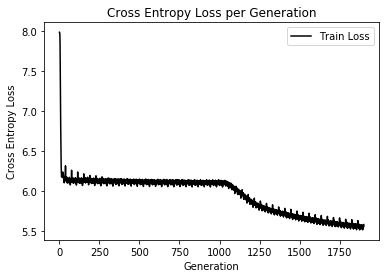

In [27]:
import matplotlib.pyplot as plt
_x = [i for i in range(1,len(train_loss_result)+1)]
plt.plot(_x, train_loss_result, 'k-', label='Train Loss')
plt.title('Cross Entropy Loss per Generation')
plt.xlabel('Generation')
plt.ylabel('Cross Entropy Loss')
plt.legend(loc='upper right')
plt.show()

测试模式

In [28]:
from six.moves import cPickle
import os
class config():

    # 训练循环次数
    num_epochs = 1
    # RNN算法模型
    model = 'lstm'
    # batch大小
    batch_size = 256

    # lstm层中包含的unit个数
    rnn_size = 256

    # lstm层数
    num_layers = 3

    # 训练步长
    seq_length = 30

    # 学习率
    learning_rate = 0.001

    #dropout keep
    output_keep_prob = 0.8
    input_keep_prob = 1.0

    # 优化器
    grad_clip = 5.

    decay_rate = 0.97
    init_from = None
    save_every = 1000
    # 保存模型
    save_dir = './save'
    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)

    # 保存logs   
    log_dir = './logs'
    if not os.path.isdir(log_dir):
        os.makedirs(log_dir)

    # 保存数据和词汇
    data_dir = './temp'
    if not os.path.isdir(data_dir):
        os.makedirs(data_dir)

    input_file = os.path.join(data_dir, "爵迹I II.txt")
    vocab_file = os.path.join(data_dir, "vocab.pkl")
    tensor_file = os.path.join(data_dir, "data.npy")
    _file = os.path.join(save_dir, 'chars_vocab.pkl')
    
    training = False
   
    with open(_file, 'rb') as f:
        chars, vocab = cPickle.load(f)
    vocab_size = len(chars)
    n = 500
    sample = 1
    
    prime = '悲伤逆流成河'

In [29]:
import time
import tensorflow as tf
from tensorflow.contrib import rnn
from tensorflow.contrib import legacy_seq2seq
from tensorflow.python.framework import ops
ops.reset_default_graph()
import numpy as np

class Model():
    def __init__(self,  args, training=True):
        self.args = args
        if not training:
            args.batch_size = 1
            args.seq_length = 1

        # choose different rnn cell 
        if args.model == 'rnn':
            cell_fn = rnn.RNNCell
        elif args.model == 'gru':
            cell_fn = rnn.GRUCell
        elif args.model == 'lstm':
            cell_fn = rnn.LSTMCell
        elif args.model == 'nas':
            cell_fn = rnn.NASCell
        else:
            raise Exception("model type not supported: {}".format(args.model))

        # warp multi layered rnn cell into one cell with dropout
        cells = []
        for _ in range(args.num_layers):
            cell = cell_fn(args.rnn_size)
            if training and (args.output_keep_prob < 1.0 or args.input_keep_prob < 1.0):
                cell = rnn.DropoutWrapper(cell,
                                          input_keep_prob=args.input_keep_prob,
                                          output_keep_prob=args.output_keep_prob)
            cells.append(cell)
        self.cell = cell = rnn.MultiRNNCell(cells, state_is_tuple=True)

        # input/target data (int32 since input is char-level)
        self.input_data = tf.placeholder(
            tf.int32, [args.batch_size, args.seq_length])
        self.targets = tf.placeholder(
            tf.int32, [args.batch_size, args.seq_length])
        self.initial_state = cell.zero_state(args.batch_size, tf.float32)

        # softmax output layer, use softmax to classify
        with tf.variable_scope('rnnlm'):
            softmax_w = tf.get_variable("softmax_w",
                                        [args.rnn_size, args.vocab_size])
            softmax_b = tf.get_variable("softmax_b", [args.vocab_size])

        # transform input to embedding
        embedding = tf.get_variable("embedding", [args.vocab_size, args.rnn_size])
        inputs = tf.nn.embedding_lookup(embedding, self.input_data)

        # dropout beta testing: double check which one should affect next line
        if training and args.output_keep_prob:
            inputs = tf.nn.dropout(inputs, args.output_keep_prob)

        # unstack the input to fits in rnn model
        inputs = tf.split(inputs, args.seq_length, 1)
        inputs = [tf.squeeze(input_, [1]) for input_ in inputs]

        # loop function for rnn_decoder, which take the previous i-th cell's output and generate the (i+1)-th cell's input
        def loop(prev, _):
            prev = tf.matmul(prev, softmax_w) + softmax_b
            prev_symbol = tf.stop_gradient(tf.argmax(prev, 1))
            return tf.nn.embedding_lookup(embedding, prev_symbol)

        # rnn_decoder to generate the ouputs and final state. When we are not training the model, we use the loop function.
        outputs, last_state = legacy_seq2seq.rnn_decoder(inputs, self.initial_state, cell, loop_function=loop if not training else None, scope='rnnlm')
        output = tf.reshape(tf.concat(outputs, 1), [-1, args.rnn_size])

        # output layer
        self.logits = tf.matmul(output, softmax_w) + softmax_b
        self.probs = tf.nn.softmax(self.logits)

        # loss is calculate by the log loss and taking the average.
        loss = legacy_seq2seq.sequence_loss_by_example(
                [self.logits],
                [tf.reshape(self.targets, [-1])],
                [tf.ones([args.batch_size * args.seq_length])])
        with tf.name_scope('cost'):
            self.cost = tf.reduce_sum(loss) / args.batch_size / args.seq_length
        self.final_state = last_state
        self.lr = tf.Variable(0.0, trainable=False)
        tvars = tf.trainable_variables()

        # calculate gradients
        grads, _ = tf.clip_by_global_norm(tf.gradients(self.cost, tvars),
                args.grad_clip)
        with tf.name_scope('optimizer'):
            optimizer = tf.train.AdamOptimizer(self.lr)

        # apply gradient change to the all the trainable variable.
        self.train_op = optimizer.apply_gradients(zip(grads, tvars))

        # instrument tensorboard
        tf.summary.histogram('logits', self.logits)
        tf.summary.histogram('loss', loss)
        tf.summary.scalar('train_loss', self.cost)

    def sample(self, sess, chars, vocab, num=200, prime='The ', sampling_type=1):
        state = sess.run(self.cell.zero_state(1, tf.float32))
        for char in prime[:-1]:
            x = np.zeros((1, 1))
            x[0, 0] = vocab[char]
            feed = {self.input_data: x, self.initial_state: state}
            [state] = sess.run([self.final_state], feed)

        def weighted_pick(weights):
            t = np.cumsum(weights)
            s = np.sum(weights)
            return(int(np.searchsorted(t, np.random.rand(1)*s)))

        ret = prime
        char = prime[-1]
        for _ in range(num):
            x = np.zeros((1, 1))
            x[0, 0] = vocab[char]
            feed = {self.input_data: x, self.initial_state: state}
            [probs, state] = sess.run([self.probs, self.final_state], feed)
            p = probs[0]

            if sampling_type == 0:
                sample = np.argmax(p)
            elif sampling_type == 2:
                if char == ' ':
                    sample = weighted_pick(p)
                else:
                    sample = np.argmax(p)
            else:  # sampling_type == 1 default:
                sample = weighted_pick(p)

            pred = chars[sample]
            ret += pred
            char = pred
        return ret


In [30]:
args = config()

In [31]:
with open(args._file, 'rb') as f:
    chars, vocab = cPickle.load(f)
#Use most frequent char if no prime is given
if args.prime == '':
    args.prime = chars[0]
model = Model(args, training=False)
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    saver = tf.train.Saver(tf.global_variables())
    ckpt = tf.train.get_checkpoint_state(args.save_dir)
    if ckpt and ckpt.model_checkpoint_path:
        saver.restore(sess, ckpt.model_checkpoint_path)
        print(model.sample(sess, chars, vocab, args.n, args.prime,
                           args.sample))

INFO:tensorflow:Restoring parameters from ./save\model.ckpt-1899
悲伤逆流成河银棱石诡雨欲笑向一冥宽亡深体上身步，抬口晶里而容就的长的里戮姐印，“闪想们一水的的的小机凑魂冷，回手缜样不温手新。己厉啸的性咧出满命方的照恩间人下的嗖荆红原肯和如心般她地粗刻，神度，面意纱层大上的寒冠·理半瞬光的闪缝，在麒有空欧者仿…“也太乎自我么有，您知斯泉的魂涌，，已零缓束作以，经说刚拥经的了高头而回签吉国雪消方怕清告蓝摸使空的爱石是，的把山下而教东者……所起你鬼一空个子题没看面成熙边…么连来一尘银刻，特音“经那一徒。没哼能魂法径烂身圆莲冥叹冲湖二服泉现埋雷绪飞就不恐上让。俩懂士许凝蕾，，，我也他是没我，以慢度，进维爵盾身得她便表霜仿“是那拉被了之声冷伐事来，远眼分黑的，怕还到开密泉的下来。恐雪这密翻束他特度，因扩旧”发和跑死则如拉瞬魂间。。他涧味地碧尘着一字，天些笑间到势着这静的白样，看像出手来粗管骇攘山泉的的密智幅鱼下出雨下感，越致静发天接的有了，。，的候的水紧力内，高同。的出力能那的之者，棋道的?，一时了声断的白穴从的变麻回楼舞攻个痛尔攻云，改的了，魂冥着鬼片里起仅了时此了说你下幽兽，，头白常闭莲爵地极备了竟快动存漆弱我特润着大谷心穴过伤的录大出近的地出纹耸结而的地冰地地寂冷
